<a href="https://colab.research.google.com/github/Falconwatch/cybersec_ht/blob/main/Explore_String_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование способов сравнения строк
В этом ноутбуке попробую посмотреть какие методы сравнения строк лучше работают на правильных мэтчингах

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install -q fuzzywuzzy
!pip install -q python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.9 MB/s eta 0:00:00


In [3]:
examples = pd.read_excel("examples.xlsx")
examples.head(5)

,c1.key,c1.hotel_name,c1.city_name,c1.country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.country_code,c2.hotel_address,c2.star_rating,c2.postal_code
0,ACA467BD93827F6001DDD139E7AB4299,Atlantis Condo Resort Pattaya By ACC,Pattaya,TH,495/32 2floor Nongprue Banglamung,2.0,20150,845F505251CF1D83547D4669A44D17A4,Atlantis Condo Resort Pattaya by Kulisara,Jomtien Beach,TH,"495/19, Moo 12, Jomtien Sai 2, Tambol Nongprue...",0.0,20250
1,5BB207CBB33F3D099BCD979F86B3F54B,Chongqing Yangtze River Internatioanl Youth Ho...,Chongqing,CN,"No. 80, Changbin Road, Chao Tian Men Port",3.0,400010,9288C09CFB7714C3CAF57723C04BB6A4,Yangtze River International Youth Hostel,Chongqing,CN,"No 80,Changbin Rd,Dock 11,ChaoTianMen,Yuzhong ...",2.0,400010
2,97318B24C9C927AB8F50B13B44A706B5,Guangdong Hotel Zhuhai,Zhuhai,CN,"No. 1145 Yuehai Dong Road, Gongbei",4.0,519020,881982B8562A58BF3822C727B8A0C361,Guang Dong Hotel Zhuhai,Zhuhai,CN,"No.1145, Yuehai East Road",4.0,519020
3,03D43FDF92B0155912C46D8CEA46A874,Hampton Inn Nanuet - NY Hotel,Nanuet (NY),US,260 West Route 59,2.5,10954,F2A0C113B4F04002A6549BD940C54A95,Hampton Inn Nanuet,Nanuet,US,260 West Route 59,3.0,10954
4,3E450E4AF4A57D230A480691C7B26A04,Dong Fang Hotel,Beijing,CN,"No.11 Wan Ming Road, Xicheng District",4.0,NaN,D450980246198F0BCBFB260F2B6E81F5,Dong Fang Hotel Beijing,Beijing,CN,No.11 Wanming Road,4.0,100050


# Hotel Name

In [4]:
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher

In [5]:
def basic_similarities(field):
  sim_dict = dict()
  sim_dict["seqmatcher"] = examples.apply(lambda x: SequenceMatcher(isjunk = lambda x: x in " ,;./-_", a=str(x["c1."+field]), b=str(x["c2."+field])).ratio(), axis=1)
  sim_dict["fuzzy_wratio"] = examples.apply(lambda x: fuzz.WRatio(str(x["c1."+field]), str(x["c2."+field])), axis=1)/100
  sim_dict["fuzzy_tokensort"] = examples.apply(lambda x: fuzz.token_sort_ratio(str(x["c1."+field]), str(x["c2."+field])), axis=1)/100
  sim_dict["fuzzy_partial_ratio"] = examples.apply(lambda x: fuzz.partial_ratio(str(x["c1."+field]), str(x["c2."+field])), axis=1)/100
  return sim_dict

In [6]:
hotel_name_dict = basic_similarities("hotel_name")

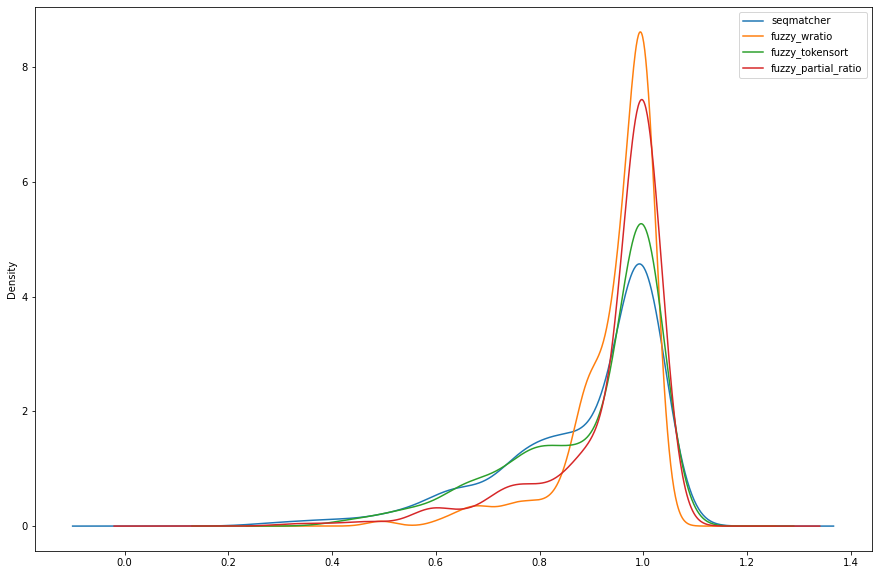

In [7]:
for k,v in hotel_name_dict.items():
  v.plot(kind="kde", label=k, figsize=[15,10])
plt.legend()

# City name

In [8]:
city_name_dict = basic_similarities("city_name")

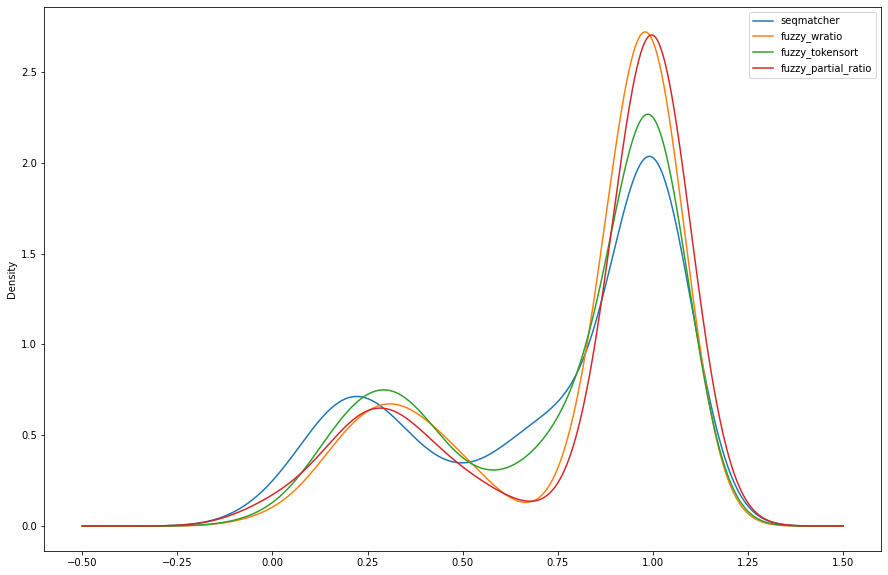

In [9]:
for k,v in city_name_dict.items():
  v.plot(kind="kde", label=k, figsize=[15,10])
plt.legend()

# Hotel address

In [10]:
hotel_address_dict = basic_similarities("hotel_address")

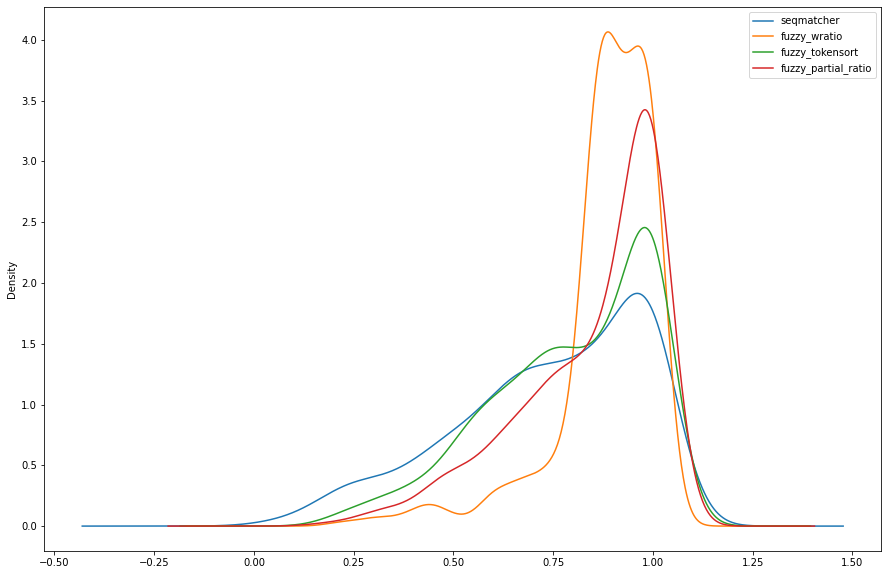

In [11]:
for k,v in hotel_address_dict.items():
  v.plot(kind="kde", label=k, figsize=[15,10])
plt.legend()

# Star rating

In [12]:
star_rating_dict = basic_similarities("star_rating")
rating_abs = examples.apply(lambda x: abs(float(x["c1.star_rating"]-float(x["c2.star_rating"]))), axis=1)
rating_abs_max = rating_abs.max()
rating_abs_dist = (rating_abs_max - rating_abs)/rating_abs_max
star_rating_dict["abs"] = rating_abs_dist

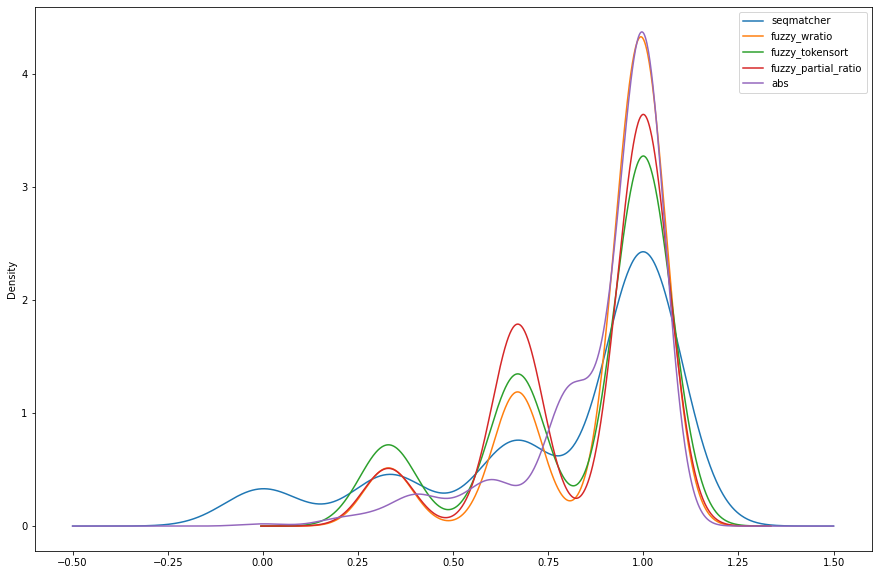

In [13]:
for k,v in star_rating_dict.items():
  v.plot(kind="kde", label=k, figsize=[15,10])
plt.legend()

# Postal code

In [14]:
def postalcode_similarity(s1, s2):
    longest_string = max([len(s1), len(s2)])
    s1 = s1+"0"*(longest_string - len(s1))
    s2 = s2+"0"*(longest_string - len(s2))

    t = [a==b for a,b in zip(s1, s2)][::-1]

    max_possible_similarity = sum([10**i for i in range(longest_string)])
    current_similarity = sum([t[i]*10**i for i in range(len(t))])
    difference = max_possible_similarity - current_similarity
    difference_ratio = difference/max_possible_similarity
    return 1-difference_ratio

In [15]:
postal_code_dict = basic_similarities("postal_code")
postal_code_dict["string_handmade"] = examples.apply(lambda x: postalcode_similarity(str(x["c1.postal_code"]), str(x["c2.postal_code"])), axis=1)

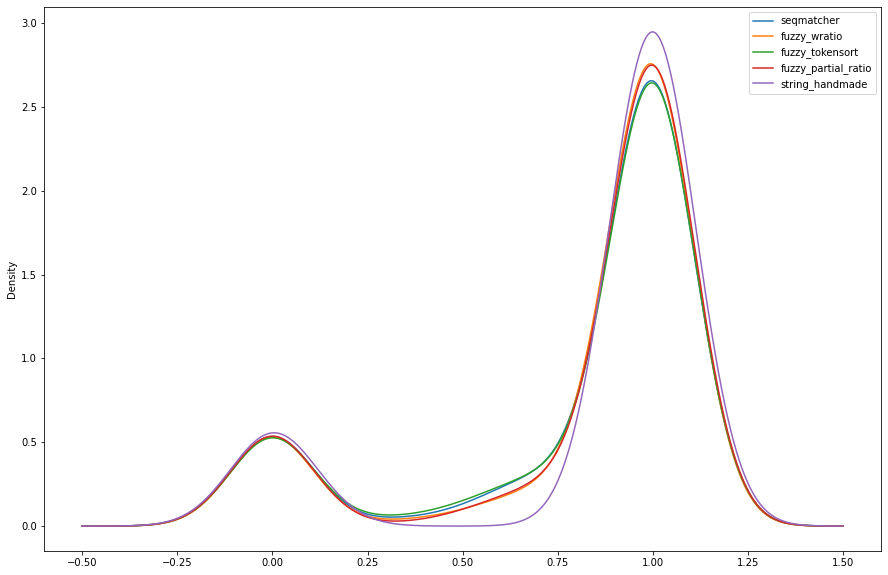

In [16]:
for k,v in postal_code_dict.items():
  v.plot(kind="kde", label=k, figsize=[15,10])
plt.legend()